# Case Study: CNN for text classification



To illustrate the process of re-implmenting a pipeline

[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). "*Learning Word Vectors for Sentiment Analysis.*" The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Yoon Kim. "[*Convolutional Neural Networks for Sentence Classification*](https://arxiv.org/abs/1408.5882)." arXiv. 2014.







In [1]:
import os.path
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

if torch.cuda.is_available():
  device = torch.device("cuda")
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  device = torch.device("cpu")
print("Device:", device)

Tesla T4
Device: cuda


Loading the data set

In [2]:
!wget -N https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar zxf aclImdb_v1.tar.gz --skip-old-files
!ls aclImdb/

--2021-05-11 13:57:36--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘aclImdb_v1.tar.gz’ not modified on server. Omitting download.

imdbEr.txt  imdb.vocab	README	test  train


In [3]:
class PolarityDataset(torch.utils.data.Dataset):
  def __init__(self, positive_dir, negative_dir, transform=None):
    assert os.path.exists(positive_dir) and os.path.isdir(positive_dir)
    self._sourcefiles = [os.path.join(positive_dir, fn) for fn in os.listdir(positive_dir) if fn.endswith(".txt")]
    self._labels = [1]*len(self._sourcefiles)
    assert os.path.exists(negative_dir) and os.path.isdir(negative_dir)
    self._sourcefiles.extend([os.path.join(negative_dir, fn) for fn in os.listdir(negative_dir) if fn.endswith(".txt")])
    self._labels.extend([0]*(len(self._sourcefiles)-len(self._labels)))
    for fn in self._sourcefiles:
      assert os.path.exists(fn), "%s is missing" % fn
    self._transform = transform

  def __len__(self):
    return len(self._sourcefiles)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    with open(self._sourcefiles[idx], 'r') as f:
      ret = {'text': f.read(), 
             'label': self._labels[idx]}
    if self._transform:
      ret = self._transform(ret)
    return ret

training_data = PolarityDataset(positive_dir="aclImdb/train/pos/", 
                                negative_dir="aclImdb/train/neg/")

for i in [0, 1, 2, 24000, 24001, 24002]:
  print(training_data[i]['label'], ":", training_data[i]['text'][:100])

1 : Well... easily my favourite TV series ever. Call me a walking mail cliché but include violence, mafi
1 : Yes, this gets the full ten stars. It's plain as day that this fill is genius. The universe sent Tre
1 : I saw this movie when I was about 8-years-old and I liked it but it wasn't until I watched it again 
0 : I loved Dewaere in Series Noir. His talent is trivialized in "The Waltzers" aka "Going Places". Okay
0 : This is one of those movies that's trying to be moody and tense, and instead, ends up tripping all o
0 : Let me just say I loved the original Boogeyman. Sure, it's a flawed clichéd 80s horror movie, but he


Create vocabulary

In [4]:
from nltk.tokenize import wordpunct_tokenize

class Tokenize(object):
    def __call__(self, data):
        text, label = data['text'], data['label']
        return {'text': [word.lower() for word in wordpunct_tokenize(text)],
                'label': label}

training_data = PolarityDataset(positive_dir="aclImdb/train/pos/", 
                                negative_dir="aclImdb/train/neg/",
                                transform=Tokenize())
test_data = PolarityDataset(positive_dir="aclImdb/test/pos/", 
                            negative_dir="aclImdb/test/neg/",
                            transform=Tokenize())

print("Loading training data...", end="")
dataset_vocab = set()
for sample in training_data:
  sample_tokens = set(sample['text'])
  dataset_vocab.update(sample_tokens)
print("done")

print("Loading test data...", end="")
for sample in test_data:
  sample_tokens = set(sample['text'])
  dataset_vocab.update(sample_tokens)
print("done")

print("Found %i tokens in the dataset" % len(dataset_vocab))

Loading training data...done
Loading test data...done
Found 104339 tokens in the dataset


## Word embedding

We need a word embedding

In [5]:
from google.colab import drive

drive.mount('/content/drive')
base = """/content/drive/MyDrive/GloVe"""
assert os.path.exists(base)
!mkdir .vector_cache
# !cp /content/drive/MyDrive/GloVe/glove.6B.zip .vector_cache
!ln -s /content/drive/MyDrive/GloVe/glove.6B.zip .vector_cache/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘.vector_cache’: File exists
ln: failed to create symbolic link '.vector_cache/glove.6B.zip': File exists


In [6]:
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=100)

400000 words in GloVe
104339 words in the dataset
75862 overlapping words


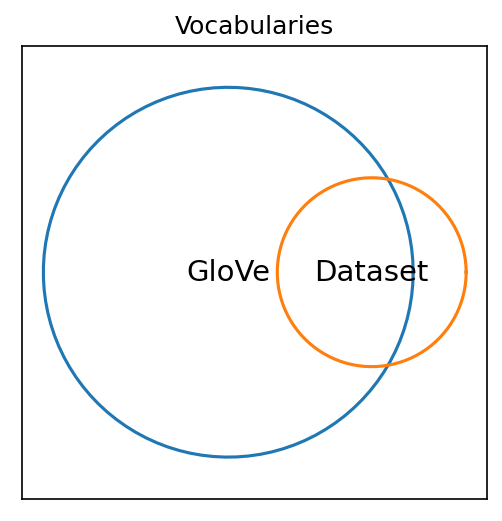

In [7]:
print("%i words in GloVe" % len(glove.itos))
print("%i words in the dataset" % len(dataset_vocab))
print("%i overlapping words" % len(dataset_vocab.intersection(set(glove.itos))))

import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

a = np.linspace(0, 2*np.pi, 100)
r1 = np.sqrt(len(glove.itos)/np.pi)
r2 = np.sqrt(len(dataset_vocab)/np.pi)
A = np.random.uniform(-r2, r2, size=(int(1000*(4/np.pi)), 2))
A = A[np.sqrt(np.sum(A**2, axis=1))<=r2, :]
p  = len(dataset_vocab.intersection(set(glove.itos)))/len(dataset_vocab)
def f(d):
  B = A.copy()
  B[:, 1] += d
  return np.abs(p-np.sum(np.sqrt(np.sum(B**2, axis=1))<=r1)/B.shape[0])
d = minimize_scalar(f, bounds=(r1-r2, r1+r2), method='bounded').x

plt.figure(figsize=(4, 4), dpi=150)
plt.plot(r1*np.cos(a), r1*np.sin(a))
plt.text(0, 0, "GloVe", fontsize=14, horizontalalignment='center', verticalalignment='center')
plt.plot(d+r2*np.cos(a), r2*np.sin(a))
plt.text(d, 0, "Dataset", fontsize=14, horizontalalignment='center', verticalalignment='center')
# A[:, 0] += d
# plt.scatter(A[:, 0], A[:, 1], s=3, c=np.sqrt(np.sum(A**2, axis=1))<=r1, marker='.', cmap='tab10')
plt.title("Vocabularies")
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()

The dataset vocabulary does not overlap completely with the embedding vocabulary. 

In [8]:
embedding_vocab = dataset_vocab.intersection(set(glove.itos))

idx2token = ['<UNK>', '<PAD>']
idx2token.extend(embedding_vocab)

token2idx = {w:i for i, w in enumerate(idx2token)}

glove.unk_init = lambda _: torch.zeros(glove.dim)
embedding_vectors = torch.stack([glove[w] for w in idx2token])

embedding = nn.Embedding(num_embeddings=embedding_vectors.size(0), 
                         embedding_dim=embedding_vectors.size(1),
                         padding_idx=token2idx['<PAD>']).from_pretrained(embedding_vectors)
embedding

Embedding(75864, 100)

In [9]:
class Encode(object):
  def __init__(self, token2idx):
    self._token2idx = token2idx
    self._vocab = set(token2idx.keys())

  def __call__(self, data):
    tokens, label = data['text'], data['label']
    tokens = [token if token in embedding_vocab else '<UNK>' for token in tokens]
    encoded = [token2idx[token] for token in tokens]
    return {'text': encoded,
            'label': label}

class ToTensor(object):
    def __call__(self, data):
        text, label = data['text'], data['label']
        return {'text': torch.LongTensor(text),
                'label': torch.LongTensor([label])}

from torchvision import transforms

training_data = PolarityDataset(positive_dir="aclImdb/train/pos/", 
                                negative_dir="aclImdb/train/neg/",
                                transform=transforms.Compose([Tokenize(), 
                                                              Encode(token2idx),
                                                              ToTensor()]))
print(training_data[0])

{'text': tensor([31312, 33833, 63004, 31129, 24588, 54649, 41888, 49607, 60197, 54537,
          325, 16102, 20099, 11813, 65817, 32911, 68647, 18662, 54596, 48546,
        54596,  2367, 54596, 53157, 54596, 52553, 61108, 60197, 55562, 16102,
        72120, 19552, 54799, 32085, 73900, 47416, 59264, 65031, 55562, 11017,
        31129, 40370, 60197, 32469, 49421, 24839, 38916, 14552, 24839,     0,
        71421, 54799, 32085, 60406, 49607, 21062, 55562, 61622, 66257, 60545,
        54596, 13924, 61079, 24839, 15005, 69813, 62964, 61622, 62192, 26942,
        19552, 12285, 62964, 49421, 57511, 24839, 15815, 61622, 40245, 25394,
        19552, 16102, 60854, 15156, 16102, 75388, 61622, 28209, 31908, 19552,
        54799, 30519, 40206, 16102, 72120, 10968, 16032, 18087, 14360, 36750,
        51620, 20487, 38916,     0, 16934,     0, 16934,     0, 24590, 49421,
        48720,  9207,  7753, 54596, 50598, 10795, 50409, 55529, 46658, 54596,
        19552, 25513,  6827, 50409, 21536, 69342, 27014

In [10]:
def collate_with_padding(batch):
  ret = {'label': torch.cat([sample['label'] for sample in batch])}
  max_length = np.max([sample['text'].size(0) for sample in batch])
  vectors = list()
  for sample in batch:
    if sample['text'].size(0) < max_length:
      vectors.append(torch.cat([sample['text'], torch.ones(max_length-sample['text'].size(0))*token2idx['<PAD>']]))
    else:
      vectors.append(sample['text'])
  ret['text'] = torch.stack(vectors).long()
  return ret

dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=0, collate_fn=collate_with_padding, pin_memory=True)
d = list(dataloader)[0]
d

{'label': tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
         0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
         1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]),
 'text': tensor([[18690, 39970, 54596,  ...,     1,     1,     1],
         [38893, 56408,  1196,  ...,     1,     1,     1],
         [73677, 32085, 23637,  ...,     1,     1,     1],
         ...,
         [ 9263, 54596, 66093,  ...,     1,     1,     1],
         [12998, 51354,    66,  ...,     1,     1,     1],
         [12998, 51354, 12292,  ...,     1,     1,     1]])}

In [11]:
class ReviewPolarity(nn.Module):
  def __init__(self, embedding, n_epochs=20, learning_rate=1, verbose=False):
    """
    """
    super(ReviewPolarity, self).__init__()
    self.n_epochs_ = n_epochs
    self.verbose = verbose
    # Define layers
    self._embedding = embedding
    self._conv3 = nn.Sequential(nn.Conv1d(self._embedding.embedding_dim, 100, kernel_size=3, padding=0),
                                nn.ReLU(),
                                nn.AdaptiveMaxPool1d(1))
    self._conv4 = nn.Sequential(nn.Conv1d(self._embedding.embedding_dim, 100, kernel_size=4, padding=0),
                                nn.ReLU(),
                                nn.AdaptiveMaxPool1d(1))
    self._conv5 = nn.Sequential(nn.Conv1d(self._embedding.embedding_dim, 100, kernel_size=5, padding=0),
                                nn.ReLU(),
                                nn.AdaptiveMaxPool1d(1))
    self._dropout = nn.Dropout(0.5)
    self._fc = nn.Sequential(nn.Linear(3*100, 2),
                             nn.LogSoftmax(dim=1))
    # Define optimiser and loss
    self.learning_rate_ = learning_rate
    self.optimizer_ = torch.optim.SGD(self.parameters(), lr=self.learning_rate_)
    self.loss_function_ = nn.NLLLoss()
    # For making nice plots
    self.training_loss_ = list()
    self.training_accuracy_ = list()
    if torch.cuda.is_available():
      self.cuda()


  def forward(self, X):
    # """Forward pass, this is used for making predictions."""
    x = self._embedding(X)
    x = x.transpose(1, 2)
    c3 = self._conv3(x)
    c4 = self._conv4(x)
    c5 = self._conv5(x)
    x = torch.cat([c3, c4, c5], dim=1)
    x = x.view(x.size(0), -1)
    x = self._dropout(x)
    x = self._fc(x)
    return x


  def fit(self, X, y=None):
    """Train the model"""
    # self._reset()
    for epoch in range(self.n_epochs_):
      if isinstance(X, torch.utils.data.dataloader.DataLoader):
        for batch in tqdm(X, desc="Training epoch %i" % epoch):
          self._fit(batch['text'], batch['label'])
      else:
        self._fit(X, y)
      if self.verbose:
        if self.n_epochs_ < 50 or (epoch % 50) == 0:
          print("Epoch %2i: Loss %.7f" % (epoch, self._loss.item()))


  def _fit(self, X, y):
    """A single step in the training"""
    if torch.cuda.is_available():
      X = X.cuda()
      y = y.cuda()
    self.zero_grad()              # Reset gradients
    forward_pass_output = self(X) # Forward pass
    self._loss = self.loss_function_(forward_pass_output, y) # Calculate loss
    self._loss.backward()         # Backward pass
    self.optimizer_.step()        # Run the optimizer one step
    # Store values for user feedback
    self.training_loss_.append(self._loss.item())
    self.training_accuracy_.append(self.score(X, y))

  def predict(self, X):
    """Predict labels"""
    return np.asarray(np.argmax(self.predict_proba(X), axis=1), dtype=np.int)


  def predict_proba(self, X):
    """Predict label probabilities"""
    if torch.cuda.is_available():
      X = X.cuda()
    with torch.no_grad():         # Disable gradient calculations
      model.eval()                # Disable dropout
      x = self(X)                 # Forward pass without dropout
      model.train()               # Enable dropout again, we need it during training
    if torch.cuda.is_available():
      x = x.cpu()
    return np.exp(x.detach().numpy())


  def score(self, X, y):
    """Get the accuracy of the model given the data"""
    if torch.cuda.is_available():
      y = y.cpu()
    return np.sum(self.predict(X)==y.numpy())/len(y)

model = ReviewPolarity(embedding=embedding, n_epochs=3, verbose=True, learning_rate=.1)

In [12]:
model.fit(dataloader)

Training epoch 1:   1%|          | 3/391 [00:00<00:18, 21.47it/s]

Epoch  0: Loss 0.5826154


Training epoch 2:   1%|          | 3/391 [00:00<00:18, 20.91it/s]

Epoch  1: Loss 0.4585692


Training epoch 2: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]

Epoch  2: Loss 0.4771730


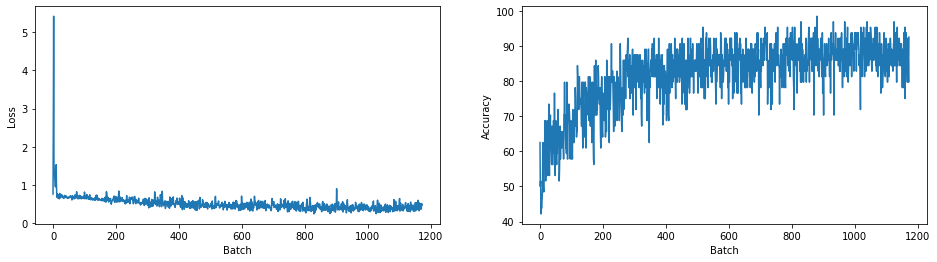

In [13]:
batches = int(np.ceil(len(training_data)/dataloader.batch_size))

fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)
ax[0].plot(model.training_loss_)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Batch")
ax[1].plot(100*np.asarray(model.training_accuracy_))
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Batch")
fig.show()

In [14]:
for p in model.parameters():
  print(p.shape)

torch.Size([75864, 100])
torch.Size([100, 100, 3])
torch.Size([100])
torch.Size([100, 100, 4])
torch.Size([100])
torch.Size([100, 100, 5])
torch.Size([100])
torch.Size([2, 300])
torch.Size([2])


In [15]:
test_data = PolarityDataset(positive_dir="aclImdb/test/pos/", 
                            negative_dir="aclImdb/test/neg/",
                            transform=transforms.Compose([Tokenize(), 
                                                          Encode(token2idx),
                                                          ToTensor()]))
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=0, 
                                               collate_fn=collate_with_padding)
accuracy = np.average([model.score(batch['text'], batch['label']) for batch in tqdm(test_data_loader, desc="Calculating test set accuracy")])
print("Test set accuracy is %.1f%%" % (100*accuracy))

Calculating test set accuracy: 100%|██████████| 391/391 [00:12<00:00, 32.56it/s]

Test set accuracy is 75.2%
